## Import standard libraries

In [1]:
import torch
import torch.nn as nn  # we'll use this a lot going forward!
import torch.nn.functional as F

import numpy as np
import warnings

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import pyplot as plt, rc

# Import json library and create function to format dictionaries.
import json
format_json = lambda x: json.dumps(x, indent=4)

# Import pandas and set pandas DataFrame visualization parameters
from IPython.display import display
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Set rendering parameters to use TeX font if not working on Juno app.
from pathlib import Path
import os
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    
# Get current working directory path for the tool parent folder and print it.
parent_folder = 'Tool'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: %s' % cwd)


Parent working directory: /Users/jjrr/Documents/SCA-Project/Tool


## Import user defined libraries

In [2]:
# Import custom libraries from local folder.
import sys
sys.path.append("..")

from library.irplib import utils, eda, config, sdg


## Import training dataset

In [3]:
# Import transformed training dataset
df = eda.import_cdm_data(os.path.join(cwd,'data','esa-challenge','train_data_transformed.csv'))

# Shuffle the DataFrame rows
df = df.sample(frac = 1, random_state=42)

# Count number of CDMs available per event
nb_cdms = df.groupby(['event_id']).count()['time_to_tca'].to_numpy(dtype=np.int32)

# Get information summary on TS suitable for training
min_cdms = 5
print(f'Events suitable for training: {np.sum(nb_cdms>min_cdms)}'
      f' ({np.sum(nb_cdms>min_cdms)/len(nb_cdms)*100:.2f}%)')
print(f'TSs with event_id integrity for training: {np.sum(nb_cdms[nb_cdms>min_cdms]-min_cdms)}')

# Show first data points to explore data types
display(df[df['event_id'].isin([0,1,2])])

Events suitable for training: 9400 (71.46%)
TSs with event_id integrity for training: 104099


,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_object_type,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
12,2,6.042352,2,-30.000000,-6.271078,181.496778,18842.0,14347.0,-700.0,-5192.1,18099.4,14.4,-13791.4,-3957.2,1.0,0.0,3.83,3.83,451,449,99.4,1.122,3.4479,2.662064,0.996299,-11.058486,7158.407846,0.000862,98.523108,-0.230120,0.236754,-0.045980,0.222933,-0.999848,0.047067,-0.998058,0.169099,-0.236669,-0.161825,0.104967,0.002330,-0.433469,-0.003761,-0.106536,UNKNOWN,1.0,0.0,14.63,14.63,15,15,100.0,1.641,NaN,1.649021,1.879016,-7.247312,7168.396232,0.001297,69.718436,-0.199922,0.552272,0.010836,0.192984,-0.999944,-0.014799,-0.999656,0.192663,-0.554558,-0.185664,0.694842,-0.051859,0.916218,0.044474,-0.699265,12.0,2.0,786.439933,774.101759,799.555083,780.963381,63.904169,-16.009902,-0.057504,134.494670,15.944390,33.940263,2.213602,3.905626,5.306960,8.812877,0.507719,4.465087,-1.562397,1.943879,-4.666855,-2.964674,-5.541783,-1.643388,71,77,23,8
20,2,3.358613,2,-30.000000,-6.263126,393.743461,18715.0,14347.0,-690.8,-5155.7,17978.5,14.4,-13791.4,-3957.2,1.0,0.0,3.56,3.56,495,494,98.7,1.074,3.4479,2.326028,0.956404,-11.214415,7158.408421,0.000862,98.523082,0.142777,0.314223,-0.002634,-0.162856,-0.998442,0.001741,-0.999557,-0.172124,-0.312443,0.192102,-0.011661,0.113241,-0.464054,-0.106686,0.008225,UNKNOWN,2.0,1.0,16.59,16.59,18,18,100.0,1.689,NaN,1.649750,1.871932,-7.274009,7168.395224,0.001295,69.718480,-0.161190,0.540377,-0.045923,0.143053,-0.999721,0.036607,-0.999372,0.129780,-0.544986,-0.111546,0.722728,-0.056988,0.935106,0.040888,-0.727519,12.0,2.0,786.440962,774.101880,799.542333,780.974116,63.902545,-16.009902,-0.057504,218.827086,12.051380,32.450691,1.724401,3.937011,3.959586,7.990369,0.405259,4.485021,-2.901702,1.121765,-5.139820,-2.933505,-5.772119,-1.638484,68,77,0,5
24,2,1.685789,2,-30.000000,-6.267365,399.243374,18709.0,14347.0,-703.0,-5160.9,17970.0,14.4,-13791.4,-3957.2,1.0,0.0,3.58,3.58,482,482,98.8,1.070,3.4479,1.976760,1.629699,-11.391150,7158.408631,0.000863,98.523093,0.234537,0.170090,0.020492,-0.270113,-0.994560,-0.004981,-0.999663,-0.259271,-0.169135,0.294564,0.067682,-0.025742,-0.510613,0.010616,-0.066809,UNKNOWN,180.0,2.0,16.59,16.59,18,18,100.0,1.689,NaN,1.649750,1.871932,-7.274009,7168.393971,0.001295,69.718480,-0.162621,0.540256,-0.045992,0.144467,-0.999721,0.036662,-0.999291,0.129144,-0.545032,-0.110886,0.722575,-0.057030,0.935107,0.040910,-0.727568,12.0,2.0,786.450368,774.092895,799.540023,780.973919,63.902484,-16.009902,-0.057504,228.543631,10.480339,32.448413,1.506042,3.937206,3.369669,7.989218,0.407631,4.485025,-3.485415,1.120667,-5.357067,-2.933585,-5.746697,-1.638485,69,77,11,6
0,0,1.566798,5,-10.204955,-7.834756,8.602101,14923.0,13792.0,453.8,5976.6,-13666.8,-7.2,-12637.0,-5525.9,1.0,0.0,3.78,3.78,459,458,98.9,1.265,0.4

## Aritificial Neural Network model for Collision Risk Probability Estimation (CRPE)

#### Embedding categorical input features

An embedding is a vector representation of a categorical variable. The representation of this vector is computed through the use of NN models/techniques that take into account potential relation between categories in order to create the vector representation for each category.

In practice, an embedding matrix is a lookup table for a vector. Each row of an embedding matrix is a vector for a unique category.

The main advantadge of using embeddings instead of One Hot/Dummy Encoding techniques (one column per unique value of categorical feature with 0s and 1s) is that it can preserve the natural order and common relationships between the categorical features. For example, we could represent the days of the week with 4 floating-point numbers each, and two consecutive days would look more similar than two weekdays that are days apart from each other.


The rule of thumb for determining the embedding size (number of elemens per array) is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [4]:
# Get input categorical and continuous features from config file.
con_features = list(config.get_features(**{'input':True, 'continuous':True}).keys())
cat_features = list(config.get_features(**{'input':True, 'continuous':False}).keys())

# Get output features
out_features = list(config.get_features(**{'input':False}).keys())

print(f'Output features:\n' + utils.tabular_list(out_features, n_cols=3, col_sep = ' - '))
print(f'Input Categorical features:\n' + utils.tabular_list(cat_features, n_cols=3, col_sep = ' - '))
print(f'Input Continuous features:\n' + utils.tabular_list(con_features, n_cols=3, col_sep = ' - '))

# Get Torch for all continuous features
conts = np.stack([df[f].to_numpy(dtype=str(df[f].dtype).lower()) for f in con_features], 1)
conts = torch.nan_to_num(torch.tensor(conts, dtype=torch.float))

# Get Torch for all categorical features
cats = np.stack([df[f].cat.codes.values for f in cat_features], 1)
cats = torch.tensor(cats, dtype=torch.int)

# Get Torch for output features
y = np.stack([df[f].to_numpy(dtype=str(df[f].dtype).lower()) for f in out_features], 1)
y = torch.tensor(y, dtype=torch.float) 

# This will set embedding sizes for the categorical columns:
# an embedding size is the length of the array into which every category
# is converted
cat_szs = [len(df[f].cat.categories) for f in cat_features]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]

for f, feature in enumerate(cat_features):
    print(f'Feature {feature:20s} Embedding size: {emb_szs[f]} '
          f'(Unique vectors: {emb_szs[f][0]} | Length: {emb_szs[f][1]})')

Output features:
 - risk                 	 - max_risk..stimate    	

Input Categorical features:
 - t_time_la..ob_start    	 - c_object_type          	 - c_time_lastob_end      	
 - t_time_lastob_end      	 - c_time_la..ob_start    	

Input Continuous features:
 - time_to_tca                  	 - t_ctdot_rdot                 	 - c_cndot_n                    	
 - miss_distance                	 - t_cndot_r                    	 - c_cndot_rdot                 	
 - relative_speed               	 - t_cndot_t                    	 - c_cndot_tdot                 	
 - relative_position_r          	 - t_cndot_n                    	 - t_span                       	
 - relative_position_t          	 - t_cndot_rdot                 	 - c_span                       	
 - relative_position_n          	 - t_cndot_tdot                 	 - t_h_apo                      	
 - relative_velocity_r          	 - c_recommended_od_span        	 - t_h_per                      	
 - relative_velocity_t          	 - c_

### Split dataset into train and test datasets

In [5]:
train_split = 0.75

train_size = int(((len(df)*train_split)//1000)*1000)
test_size = len(df) - train_size

print(f'Train size: {train_size} \t Test size: {test_size}')

cat_train = cats[:train_size-test_size]
cat_test = cats[train_size-test_size:train_size]
con_train = conts[:train_size-test_size]
con_test = conts[train_size-test_size:train_size]
y_train = y[:train_size-test_size]
y_test = y[train_size-test_size:train_size]

Train size: 121000 	 Test size: 41634


### Initialize CollisionRisk model

Training Collision Risk model | MSE loss = 5.08157301 : 100%|██████████| 500/500 [05:13<00:00,  1.60it/s]  


Final MSE loss: 5.08157301
Traning duration: 313 seconds.
Saving model parameters... Done.



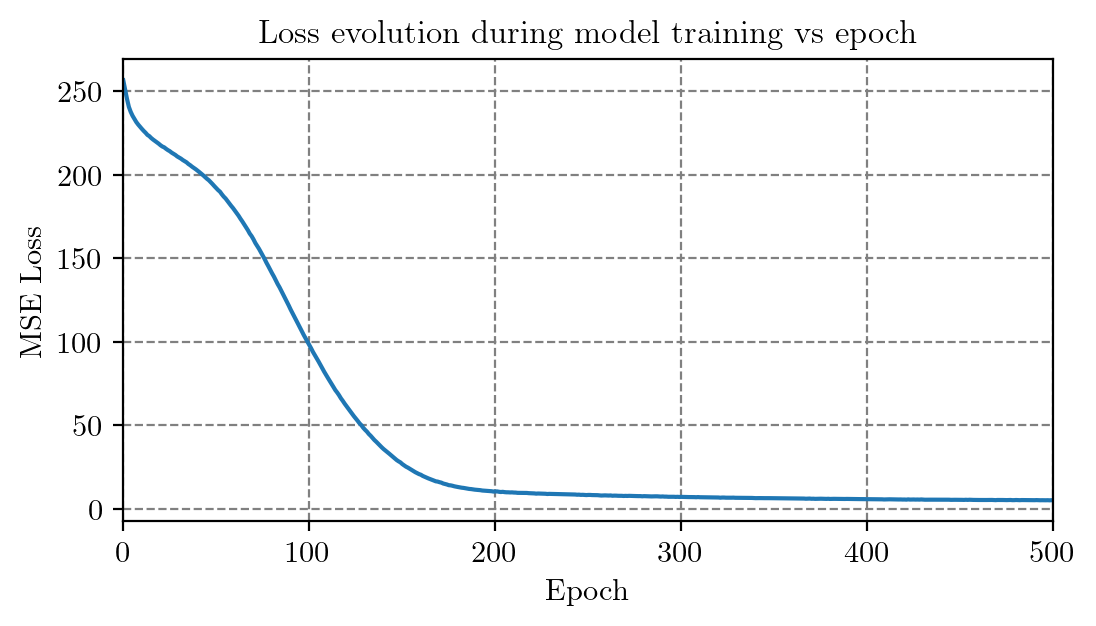

In [6]:
import time
from tqdm import trange
from library.irplib import ann

# Set manual seed
torch.manual_seed(33)

layers = [200, 400, 300, 100]
n_out = len(out_features)
n_conts = conts.shape[1]

# Define loss function (criterion)
criterion = nn.MSELoss()

# Initialize model from ann library
model = ann.CollisionRisk(emb_szs, n_conts, n_out, layers, p=0.4)

# Print model structure
model

# Get time-series sets for every continuous variable feature 
# (constant features by definition do not need to be forecasted)
model_filename = 'CollisionRiskModel.pt'

# Check if tensors pt file is available in the data folder
filepath = os.path.join(cwd,'models','ann', model_filename)

# Import model settings if exists
if os.path.exists(filepath):
    model.load_state_dict(torch.load(filepath))

    # Set dropout and batch normalization layers to evaluation mode before running inference.
    model.eval()

    print(f'Model parameters imported successfully from:\n{filepath}')
else:

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002) 

    start_time = time.time()

    epochs = 500
    losses = np.ones(epochs)*np.inf

    t = trange(epochs, desc='Training Collision Risk model', leave=True)

    for e in t:
        
        # Predict values using the model
        y_pred = model(cat_train, con_train)

        # Compute loss using the criterion
        loss = criterion(y_pred, y_train)

        t.set_description(f'Training Collision Risk model | MSE loss = {loss.item():10.8f} ')
        t.refresh() # to show immediately the update

        # Add computed loss to the losses array for analysis
        losses[e] = loss.detach().numpy()

        optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Adjust parameters of the optimizer 
        optimizer.step()

    print(f'\nFinal MSE loss: {losses[-1]:10.8f}'
          f'\nTraning duration: {time.time() - start_time:.0f} seconds.')

    # Save the model trained parameters (weights and biases)
    print('Saving model parameters...', end='\r')
    torch.save(model.state_dict(), filepath)
    print('Saving model parameters... Done.\n')

    # Plot loss evolution during training
    plt.figure(figsize=(6,3))
    plt.title(r'Loss evolution during model training vs epoch', fontsize=12)
    plt.plot(range(epochs), losses)
    plt.xlim(0, epochs)
    plt.ylabel('MSE Loss')
    plt.xlabel('Epoch')
    plt.grid(True, linestyle='--', c='grey')
    plt.show()




## Model evaluation

In [7]:
# Evaluate entire dataset
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'MSE loss on test dataset: {loss:.8f}')

MSE loss on test dataset: 6.07023382


In [8]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score as accuracy, precision_score as precision
from sklearn.metrics import f1_score as f1, recall_score as recall

# Define risk threshold for collision avoidance manouvre.
risk_threshold = -4.0

# Get outputs from the model from the entire dataset.
output = []
for i in range(len(y_test)):
    y_pred = y_val[i][0].item()
    y_true = y_test[i][0].item()
    diff = np.abs(y_pred-y_true)

    output.append([y_pred, y_true, diff, y_pred>=risk_threshold, y_true>=risk_threshold])
    

# Create DataFrame with the results and print the first rows
df_val = pd.DataFrame(data=output, columns=['pred_risk','true_risk', 'delta', 'pred_avoidance_flag', 'true_avoidance_flag'])
display(df_val.head(10))

# Evaluate accuracy using the confusion matrix.
y_true = df_val['true_avoidance_flag']
y_pred = df_val['pred_avoidance_flag']

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print(f'Model accuracy  = {accuracy(y_true, y_pred)*100:5.2f}%\n')
print(f'TP: {tp:^6} FP: {fp:^6}\n'
      f'FN: {fn:^6} TN: {tn:^6}')

,pred_risk,true_risk,delta,pred_avoidance_flag,true_avoidance_flag
0,-5.761452,-5.552532,0.208920,False,False
1,-20.565798,-30.000000,9.434202,False,False
2,-27.793129,-30.000000,2.206871,False,False
3,-33.290962,-30.000000,3.290962,False,False
4,-5.280630,-5.577574,0.296945,False,False
5,-26.958017,-30.000000,3.041983,False,False
6,-14.613995,-13.477035,1.136960,False,False
7,-29.446091,-30.000000,0.553909,False,False
8,-12.677701,-11.262410,1.415291,False,False
9,-6.876757,-8.261299,1.384542,False,False


Model accuracy  = 98.84%

TP:   34   FP:  340  
FN:  142   TN: 41118 



## Save the trained model to a file
Right now <strong><tt>model</tt></strong> has been trained and validated, and seems to correctly classify an iris 97% of the time. Let's save this to disk.<br>
The tools we'll use are <a href='https://pytorch.org/docs/stable/torch.html#torch.save'><strong><tt>torch.save()</tt></strong></a> and <a href='https://pytorch.org/docs/stable/torch.html#torch.load'><strong><tt>torch.load()</tt></strong></a><br>

There are two basic ways to save a model.<br>

The first saves/loads the `state_dict` (learned parameters) of the model, but not the model class. The syntax follows:<br>
<tt><strong>Save:</strong>&nbsp;torch.save(model.state_dict(), PATH)<br><br>
<strong>Load:</strong>&nbsp;model = TheModelClass(\*args, \*\*kwargs)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.load_state_dict(torch.load(PATH))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.eval()</tt>

The second saves the entire model including its class and parameters as a pickle file. Care must be taken if you want to load this into another notebook to make sure all the target data is brought in properly.<br>
<tt><strong>Save:</strong>&nbsp;torch.save(model, PATH)<br><br>
<strong>Load:</strong>&nbsp;model = torch.load(PATH))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.eval()</tt>

In either method, you must call <tt>model.eval()</tt> to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

For more information visit https://pytorch.org/tutorials/beginner/saving_loading_models.html